In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [77]:
import pandas as pd
# Load the Rotten Tomatoes polarity dataset
def load_rt_dataset():
    reviews = []
    for sentiment in ['pos', 'neg']:
        path = f'/content/drive/MyDrive/A3/rt-polarity.{sentiment}'
        file = open(path)
        for line in file.readlines():
            review = line.strip()
            reviews.append({'review': review, 'sentiment': sentiment})
    return pd.DataFrame(reviews)

reviews = load_rt_dataset()
print(reviews.head())

                                              review sentiment
0  the rock is destined to be the 21st century's ...       pos
1  the gorgeously elaborate continuation of " the...       pos
2                     effective but too-tepid biopic       pos
3  if you sometimes like to go to the movies to h...       pos
4  emerges as something rare , an issue movie tha...       pos


In [78]:
# Q1

import re
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('punkt')

# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess(text : str) -> list:
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)

    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word]

    return tokens

# Preprocess all documents
preprocessed_documents = reviews['review'].apply(preprocess)
print(f'Number of preprocessed documents: {len(preprocessed_documents)}')
print(preprocessed_documents.head())

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Number of preprocessed documents: 10662
0    [the, rock, is, destined, to, be, the, st, cen...
1    [the, gorgeously, elaborate, continuation, of,...
2                   [effective, but, tootepid, biopic]
3    [if, you, sometimes, like, to, go, to, the, mo...
4    [emerges, a, something, rare, an, issue, movie...
Name: review, dtype: object


In [79]:
# Q3

# Make a token2index dictionary and a index2token dictionary and convert the documents to sequences of indices
token2index = {}
index2token = {}
index = 1 # reserve 0 for padding
for document in preprocessed_documents:
    for token in document:
          if token not in token2index:
              token2index[token] = index
              index2token[index] = token
              index += 1

token2index['[PAD]'] = 0
index2token[0] = '[PAD]'

print(f'Number of unique tokens: {len(token2index)}')

Number of unique tokens: 18320


In [80]:
# Q2

# Convert the dataset into sequences of indices
def document_to_sequence(document : str) -> list:
    return [token2index[token] for token in document]

sequences = preprocessed_documents.apply(document_to_sequence)
print(sequences.head()) # should now be a list of indices

# Truncate the sequences
def pad_sequence(sequence: list, max_length: int, padding_token: int = 0) -> list:
    if len(sequence) > max_length:
        return sequence[:max_length]
    else:
        return sequence + [padding_token] * (max_length - len(sequence))
    pass

# Maximum sequence length
max_length = 50

# Truncate the sequences
truncated_sequences = sequences.apply(lambda x: pad_sequence(x, max_length))

print(truncated_sequences.head())

0    [1, 2, 3, 4, 5, 6, 1, 7, 8, 9, 10, 11, 12, 13,...
1    [1, 29, 30, 31, 32, 1, 33, 32, 1, 34, 35, 3, 3...
2                                     [52, 53, 54, 55]
3    [56, 57, 58, 59, 5, 60, 5, 1, 61, 5, 62, 63, 6...
4    [68, 16, 69, 70, 71, 72, 61, 73, 36, 74, 11, 7...
Name: review, dtype: object
0    [1, 2, 3, 4, 5, 6, 1, 7, 8, 9, 10, 11, 12, 13,...
1    [1, 29, 30, 31, 32, 1, 33, 32, 1, 34, 35, 3, 3...
2    [52, 53, 54, 55, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
3    [56, 57, 58, 59, 5, 60, 5, 1, 61, 5, 62, 63, 6...
4    [68, 16, 69, 70, 71, 72, 61, 73, 36, 74, 11, 7...
Name: review, dtype: object


In [81]:
# Q4

import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader

# Split the dataset into training and testing sets
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(truncated_sequences, reviews['sentiment'], test_size=0.2, random_state=123)
X_test, X_val, y_test, y_val = train_test_split(X_test_and_val, y_test_and_val, test_size=0.5, random_state=42)

# Encode the target variable
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train.tolist())
y_val = label_encoder.transform(y_val.tolist())
y_test = label_encoder.transform(y_test.tolist())

# Convert the vectorized reviews to numpy arrays
X_train = torch.tensor(X_train.tolist())
X_val = torch.tensor(X_val.tolist())
X_test = torch.tensor(X_test.tolist())
y_train = torch.tensor(y_train)
y_val = torch.tensor(y_val)
y_test = torch.tensor(y_test)

# Define the dataset class
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

# Define the dataloader
batch_size = 16
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=len(test_data))

# check the first sequence with index2token
print([index2token[i.item()] for i in train_data.tensors[0][0]])

['not', 'everything', 'work', 'but', 'the', 'average', 'is', 'higher', 'than', 'in', 'mary', 'and', 'most', 'other', 'recent', 'comedy', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [82]:
# Q5

import torch.nn as nn
import torch.optim as optim

class Net(nn.Module):
    def __init__(self, input_size: int, output_size: int, hidden_size: int, num_embeddings: int, embedding_dim: int,
                 padding_idx: int = 0, pretrained_embeddings: torch.Tensor = None, freeze_embeddings: bool = False):
        super(Net, self).__init__()
        if pretrained_embeddings is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, padding_idx=padding_idx, freeze=freeze_embeddings)
        else:
            self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim, padding_idx=padding_idx)
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(hidden_size, output_size)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        x = torch.mean(x, dim=1) # take the mean of the embeddings
        x = self.activation(self.linear1(x))
        return self.sigmoid(self.linear2(x))

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [98]:
#################### Training Loop ####################

def train_model(model):

  # Define the loss function and the optimizer
  criterion = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  early_stopper = EarlyStopper(2,0.01)

  # Train the model
  for epoch in range(num_epochs):
      model.train() # Training mode
      total_train_loss = 0.0

      for _, (input_, target) in enumerate(train_loader):
          optimizer.zero_grad()
          output = model(input_)
          target = target.float().unsqueeze(1)
          loss = criterion(output, target)
          loss.backward()
          optimizer.step()
          total_train_loss += loss.item()

      train_loss = total_train_loss / len(train_loader)

      # Validation
      model.eval()
      val_losses = []
      # Extract the input and target variables from each validation batch
      for input_, target in val_loader:
          with torch.no_grad():
              output = model(input_)
              target = target.float().unsqueeze(1)
              val_loss = criterion(output, target)
              val_losses.append(val_loss.item())

      val_loss = sum(val_losses) / len(val_losses)
      if early_stopper.early_stop(val_loss):
          break

      print('training loss: %.4f' % train_loss)
      print('validation loss: %.4f' % val_loss)

In [108]:
d = 50
h = 50
batch_size = 16
num_epochs = 10
learning_rate = 0.001

model = Net(
    input_size=d,
    output_size=1,
    hidden_size=h,
    num_embeddings=len(token2index),
    embedding_dim=d,
    padding_idx=0
)

train_model(model)

training loss: 0.6819
validation loss: 0.6555
training loss: 0.5882
validation loss: 0.6007
training loss: 0.4641
validation loss: 0.5908
training loss: 0.3597
validation loss: 0.6069


In [109]:
# Q6

#################### Evaluation ####################

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model):
  # Evaluate the model
  for batch in test_loader:
      test_inputs, test_targets = batch
  with torch.no_grad():
      test_outputs = model(test_inputs)

  predictions = test_outputs.view(-1)
  predictions = torch.tensor([1 if x >= 0.5 else 0 for x in predictions])
  print(f'accuracy: {accuracy_score(test_targets, predictions)}')
  print(f'precision: {precision_score(test_targets, predictions)}')
  print(f'recall: {recall_score(test_targets, predictions)}')
  print(f'f1: {f1_score(test_targets, predictions)}')

In [110]:
# Evaluate Simple Embedding
evaluate_model(model)

accuracy: 0.7392120075046904
precision: 0.725897920604915
recall: 0.7427466150870407
f1: 0.734225621414914


In [169]:
# Q7

################## Getting GloVe embeddings ##################

import gensim.downloader as api
embedding_dim = 50
word_vectors = api.load(f"glove-wiki-gigaword-{embedding_dim}")

# Create the embedding matrix with the pretrained embeddings and the token2index dictionary
embedding_matrix = torch.zeros(len(token2index), embedding_dim)
for token, index in token2index.items():
    if token in word_vectors:
        embedding_matrix[index] = torch.tensor(word_vectors[token])

In [116]:
d = 50
h = 50
batch_size = 16
num_epochs = 10
learning_rate = 0.001

model1 = Net(
    input_size=d,
    output_size=1,
    hidden_size=h,
    num_embeddings=len(token2index),
    embedding_dim=d,
    padding_idx=0,
    pretrained_embeddings=embedding_matrix,
    freeze_embeddings=False
)

train_model(model1)

training loss: 0.6429
validation loss: 0.5868
training loss: 0.4857
validation loss: 0.5238
training loss: 0.3597
validation loss: 0.5245
training loss: 0.2649
validation loss: 0.5557


In [117]:
evaluate_model(model1)

accuracy: 0.7664165103189493
precision: 0.7780082987551867
recall: 0.7253384912959381
f1: 0.7507507507507507


In [119]:
# Freeze GloVe embeddings

d = 50
h = 50
batch_size = 16
num_epochs = 10
learning_rate = 0.001

model2 = Net(
    input_size=d,
    output_size=1,
    hidden_size=h,
    num_embeddings=len(token2index),
    embedding_dim=d,
    padding_idx=0,
    pretrained_embeddings=embedding_matrix,
    freeze_embeddings=True
)

train_model(model2)

training loss: 0.6711
validation loss: 0.6470
training loss: 0.6225
validation loss: 0.6190
training loss: 0.6028
validation loss: 0.6076
training loss: 0.5935
validation loss: 0.6021
training loss: 0.5882
validation loss: 0.5984
training loss: 0.5848
validation loss: 0.5958
training loss: 0.5822
validation loss: 0.5935
training loss: 0.5800
validation loss: 0.5910
training loss: 0.5779
validation loss: 0.5905
training loss: 0.5763
validation loss: 0.5890


In [120]:
evaluate_model(model2)

accuracy: 0.6697936210131332
precision: 0.6987951807228916
recall: 0.5609284332688588
f1: 0.6223175965665236


In [122]:
embeddings = model.embedding.weight.data
embeddings[token2index['good']]

tensor([-0.2271,  0.6327, -0.7300, -0.1533,  1.0946, -0.4179, -0.7290, -0.0544,
         0.1246,  0.7224,  0.0379,  0.8247, -0.5905, -0.1910,  0.2409, -0.0500,
         0.6867,  0.3686, -0.1569, -0.6870, -0.4132,  0.8041,  0.0577, -0.1597,
         1.0730, -1.5285, -0.9217,  0.0255,  0.7933, -0.2738,  3.6827,  0.9158,
        -0.2345, -0.1649,  0.1437, -0.2140, -0.2753,  1.0204,  0.1079, -0.8296,
         0.0983, -0.1224,  0.0169,  0.1377, -0.0509,  0.3062, -0.1995,  0.1099,
         0.1559,  1.0335])

In [142]:
# Q8

# Get nearest neighbors using cosine similarity
import numpy as np

def cosine_similarity(a, b):
    norm1 = np.linalg.norm(a)
    norm2 = np.linalg.norm(b)

    if norm1 == 0 or norm2 == 0:
        return 0

    return np.dot(a, b) / (norm1 * norm2)


def k_nearest_neighbors(embeddings, token2index, token, k: int = 5):
    if token not in token2index:
        raise ValueError(f"Token '{token}' not found in token2index dictionary.")

    idx = token2index[token]
    vec = embeddings[idx]

    similarities = []
    for i, vec1 in enumerate(embeddings):
        if i != idx:
            similarity = cosine_similarity(vec, vec1)
            similarities.append((i, similarity))

    similarities.sort(key=lambda x: x[1], reverse=True)
    nearest_neighbors = [idx for idx, _ in similarities[:k]]

    index2token = {idx: tok for tok, idx in token2index.items()}
    return [index2token[idx] for idx in nearest_neighbors]

In [144]:
# Get the nearest neighbors of the word 'good'
k_nearest_neighbors(embeddings, token2index, 'good', k=10)

['always',
 'way',
 'sure',
 'definitely',
 'you',
 'something',
 'lot',
 'everyone',
 'maybe',
 'easy']

In [145]:
# Embeddings from GloVe
embeddings1 = model1.embedding.weight.data
k_nearest_neighbors(embeddings1, token2index, 'good', k=10)

['always',
 'way',
 'sure',
 'something',
 'better',
 'definitely',
 'you',
 'make',
 'lot',
 'kind']

In [152]:
# Q9

import nltk
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


def plot_embeddings_3d(embeddings, num_embeddings_to_plot: int = 250):

  # Don't plot stopwords
  non_stop_words = [token for token in list(token2index.keys()) if token not in stop_words]
  indices_to_take = [token2index[token] for token in non_stop_words[:num_embeddings_to_plot]]
  subset_of_embeddings = embeddings[indices_to_take, :]

  # PCA
  pca = PCA(n_components=3)
  components = pca.fit_transform(subset_of_embeddings)

  # Create a 3D scatter plot of the projection
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(components[:, 0], components[:, 1], components[:, 2], s=10)

  for i, index_in_dict in enumerate(indices_to_take):
      token = index2token[index_in_dict]
      ax.text(components[i, 0], components[i, 1], components[i, 2], token)
  plt.show()

def plot_embeddings_tsne(embeddings, num_embeddings_to_plot: int = 2000, pca_n_components: int = 50):

  # Don't plot stopwords
  non_stop_words = [token for token in list(token2index.keys()) if token not in stop_words]
  indices_to_take = [token2index[token] for token in non_stop_words[:num_embeddings_to_plot]]
  subset_of_embeddings = embeddings[indices_to_take, :]

  random_state = 42
  vocab = [index2token[index] for index in indices_to_take]
  colors = ['black' for i in vocab]
  # reduction with PCA
  pca = PCA(n_components=pca_n_components, random_state=random_state)
  X = pca.fit_transform(subset_of_embeddings)
  # t-SNE:
  tsne = TSNE(
      n_components=2,
      init='random',
      learning_rate='auto',
      random_state=random_state)
  tsnemat = tsne.fit_transform(X)
  # Plot values:
  xvals = tsnemat[: , 0]
  yvals = tsnemat[: , 1]
  # Plotting:
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,30))
  ax.plot(xvals, yvals, marker='', linestyle='')
  # Text labels:
  for word, x, y, color in zip(vocab, xvals, yvals, colors):
      try:
          ax.annotate(word, (x, y), fontsize=8, color=color)
      except UnicodeDecodeError:
          pass
  plt.axis('off')
  plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


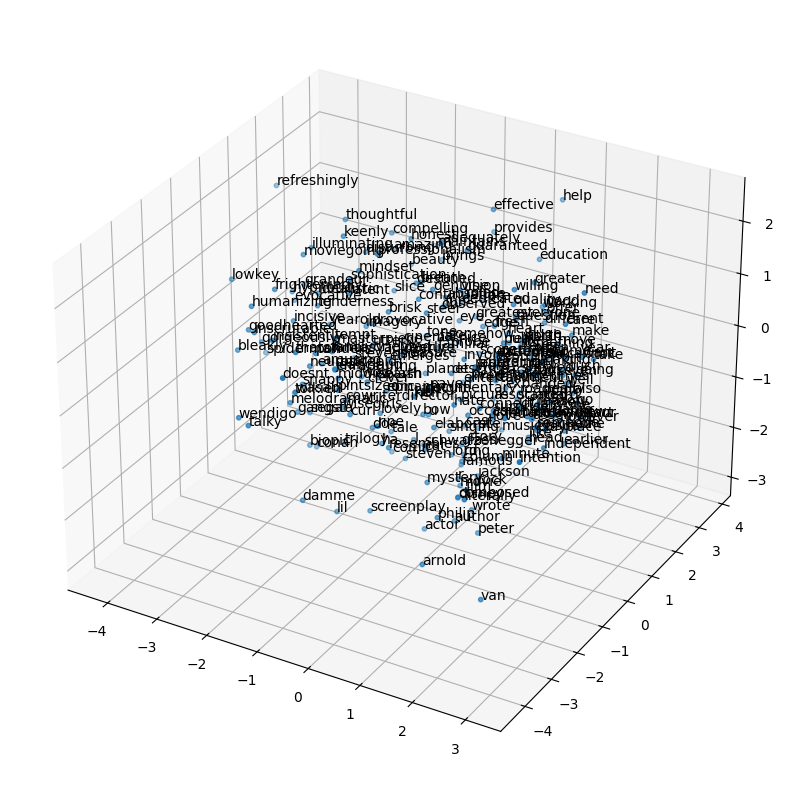

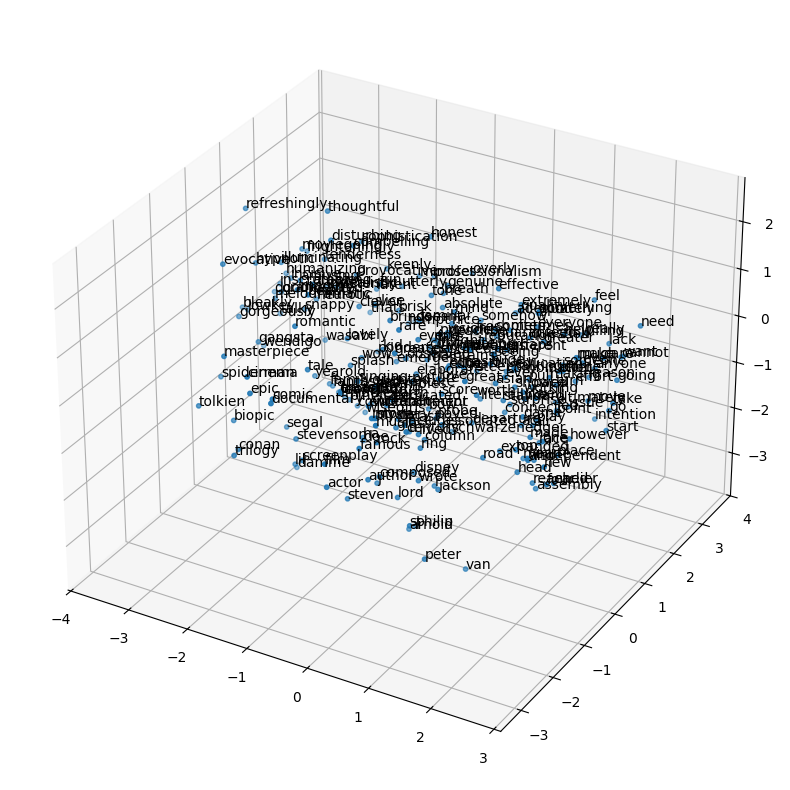

In [153]:
# Trained Embedding
plot_embeddings_3d(embeddings)

# Glove Embedding
plot_embeddings_3d(embeddings1)

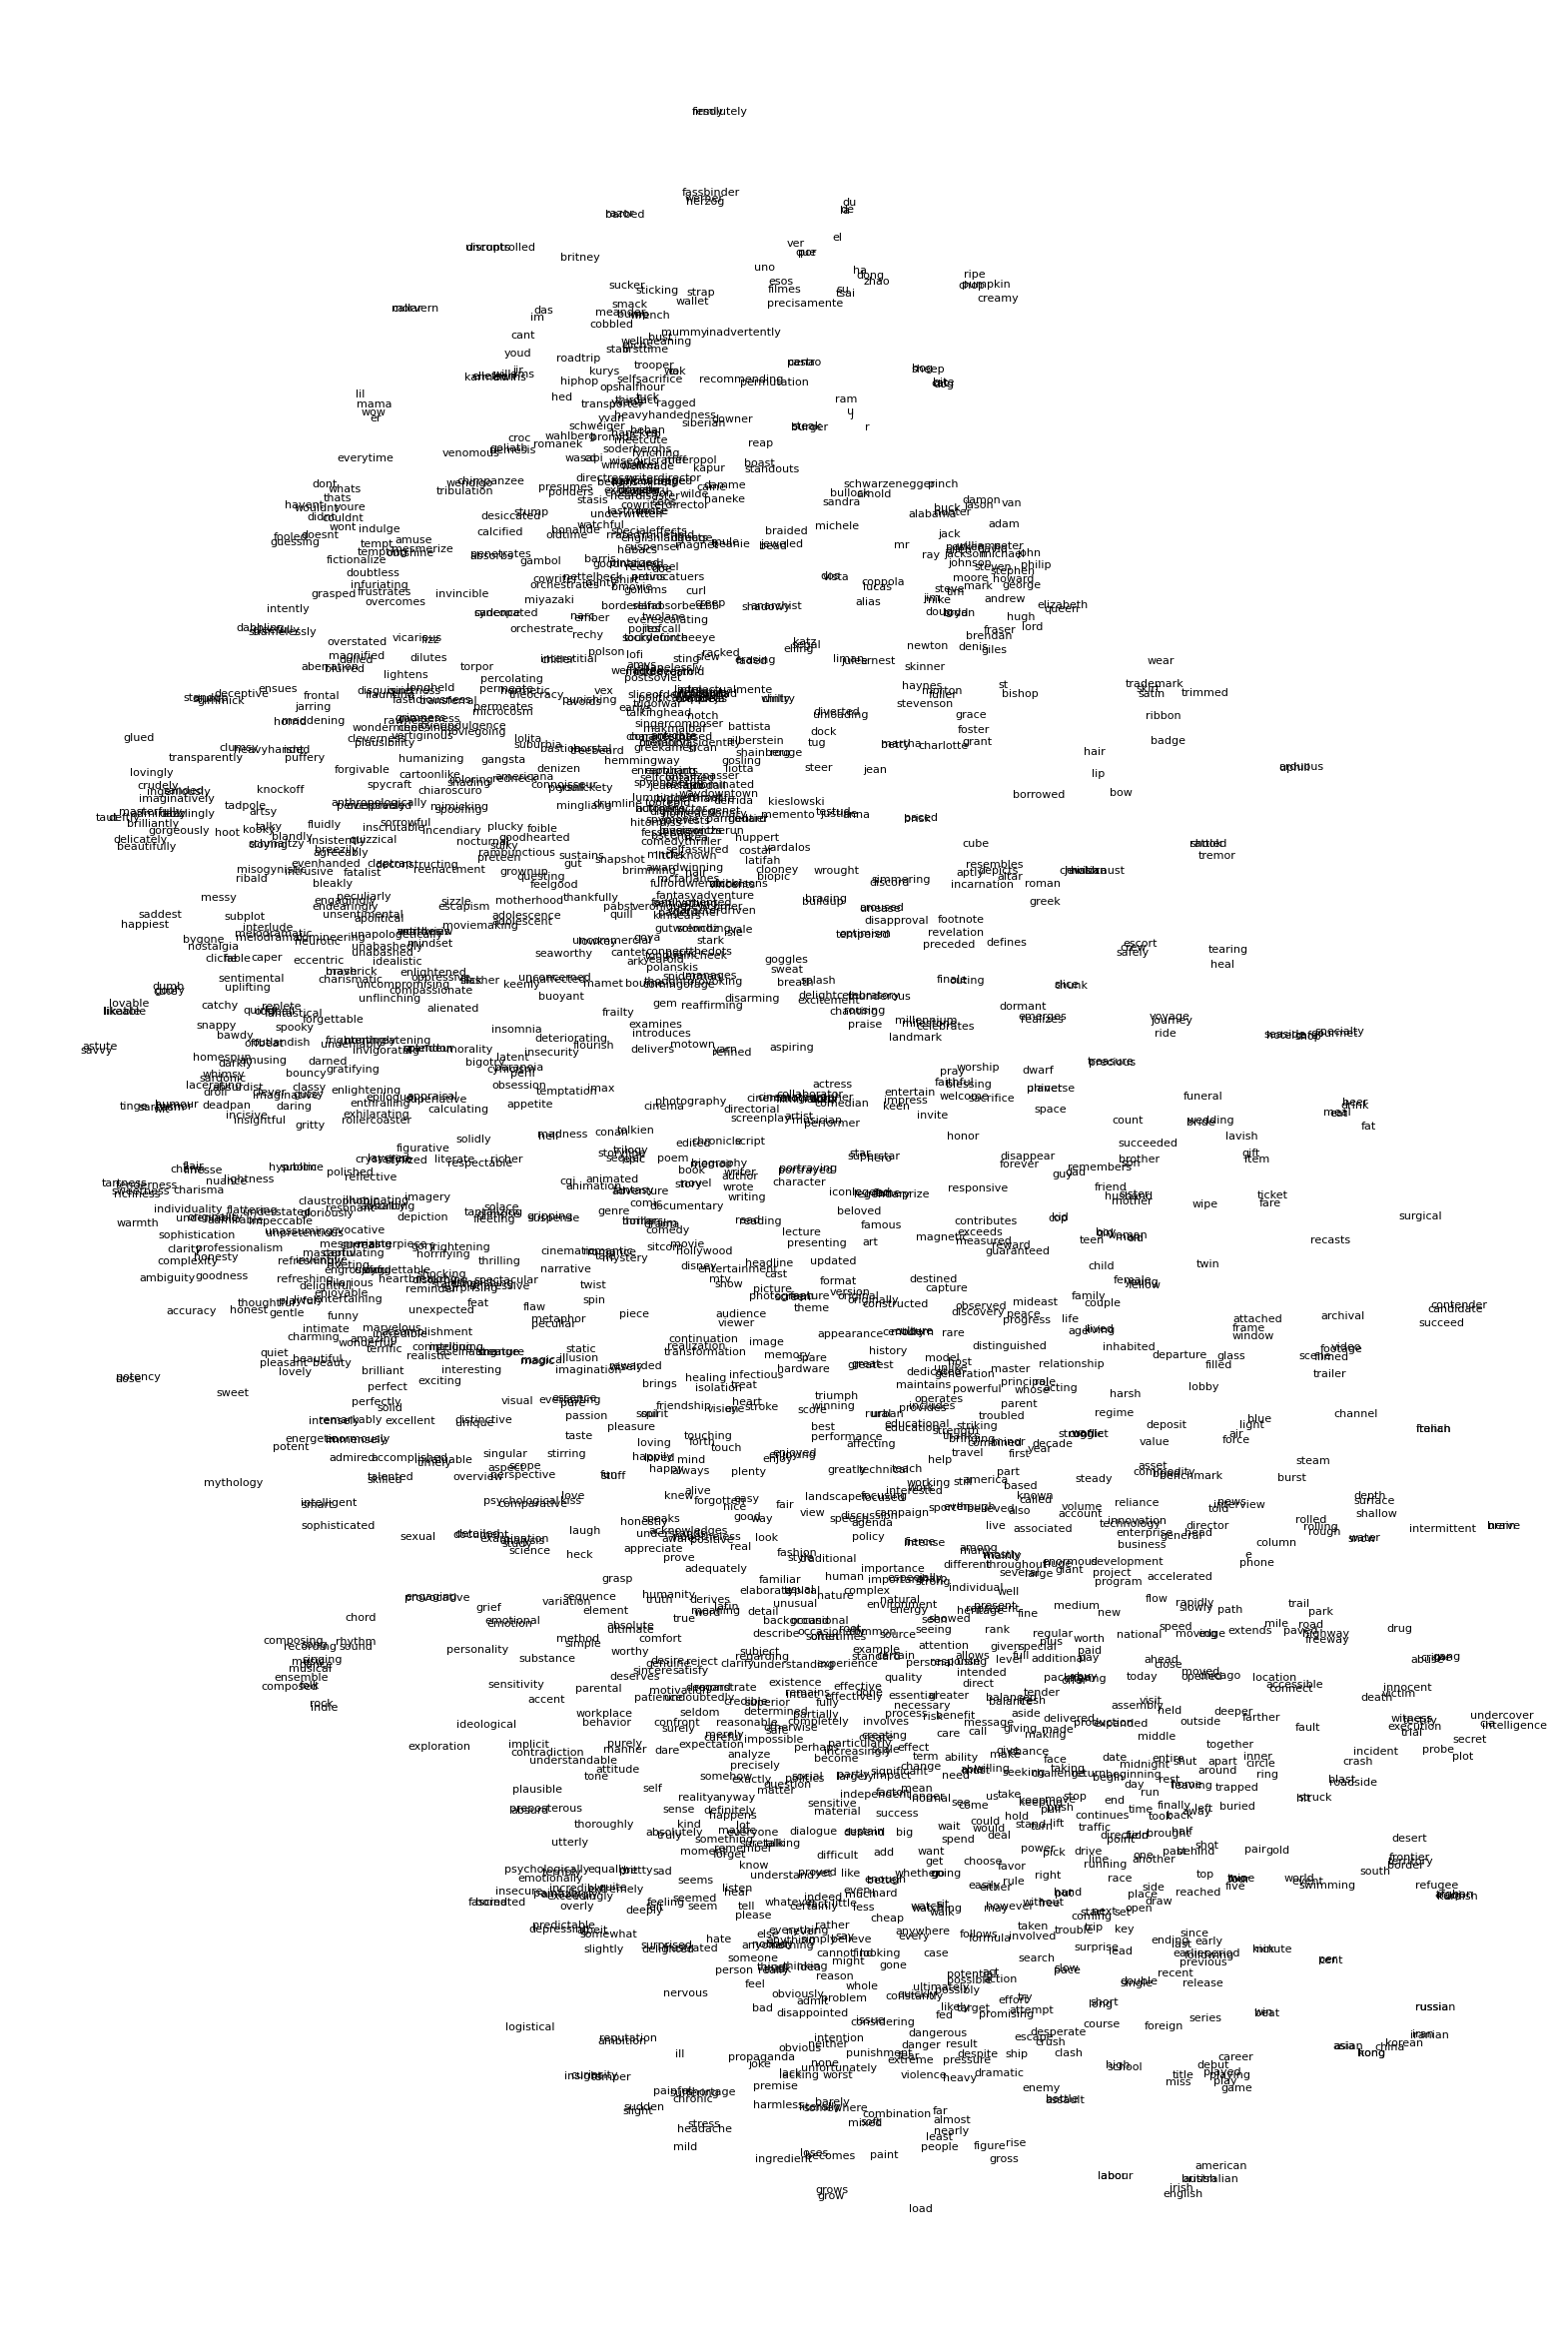

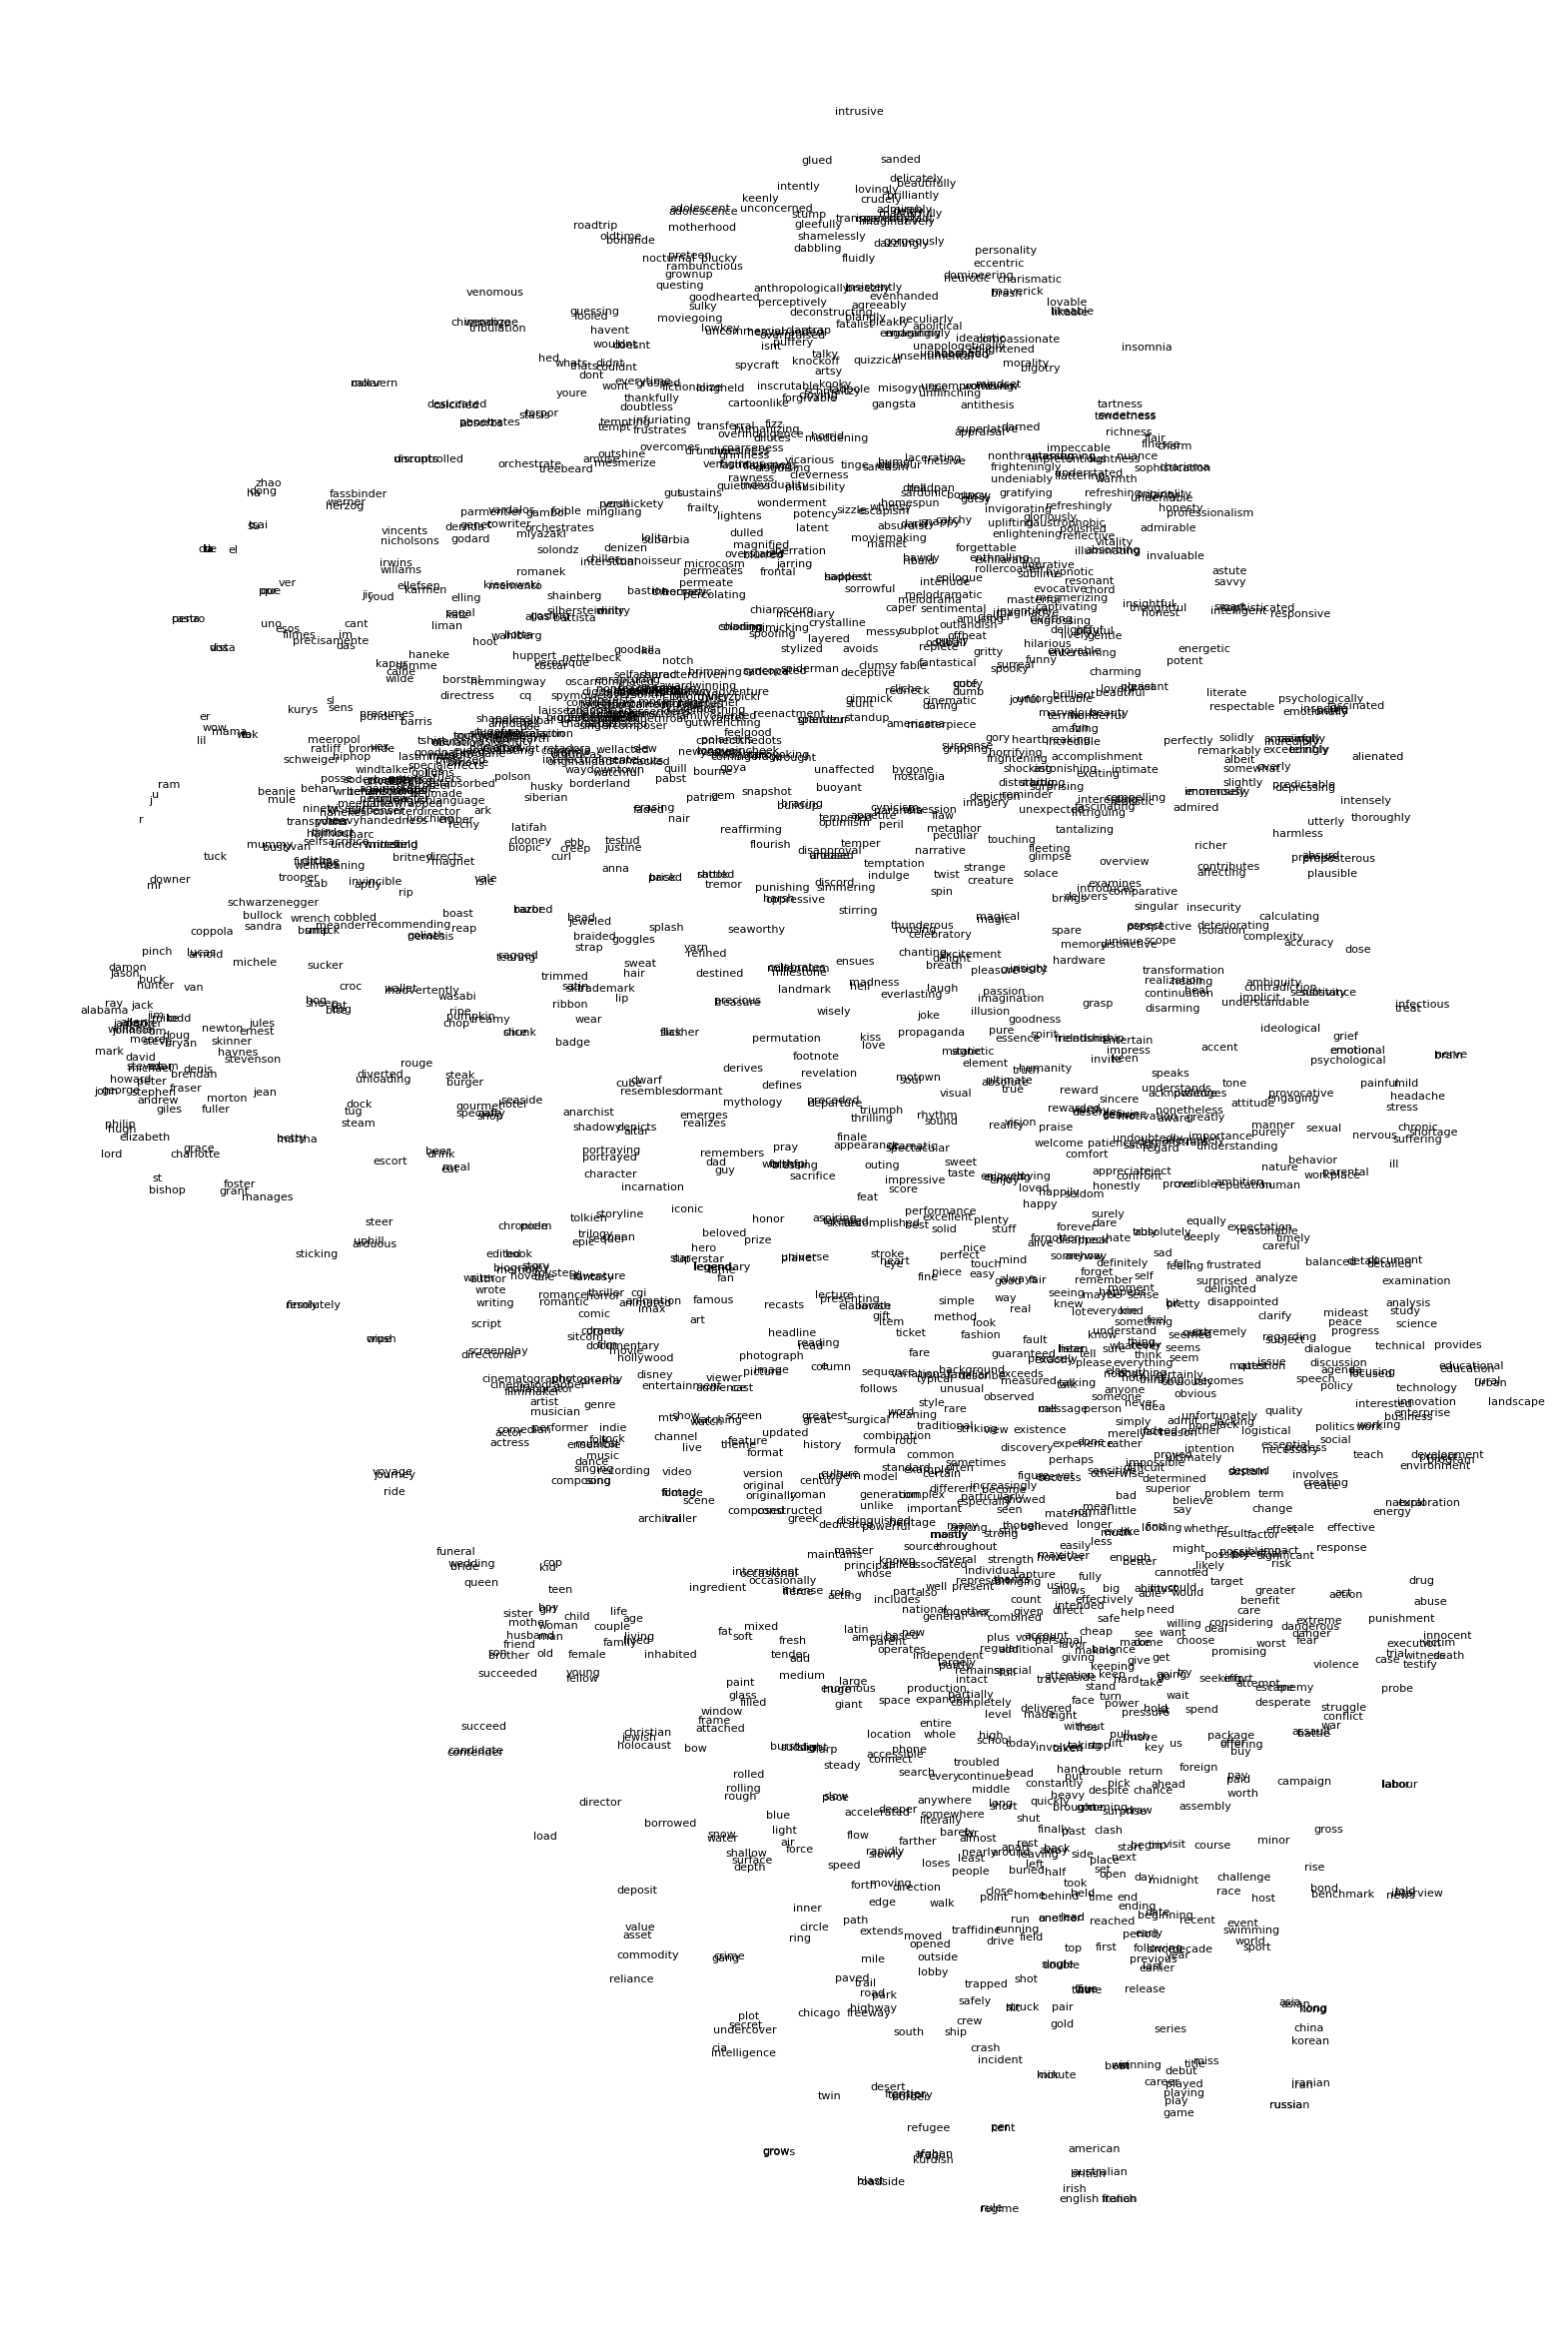

In [154]:
# Trained Embedding
plot_embeddings_tsne(embeddings)

# Glove Embedding
plot_embeddings_tsne(embeddings1)

In [185]:
# Report - Q1

def document_to_sequence(document : str) -> list:
    return [token2index[token] for token in document]

sequences = preprocessed_documents.apply(document_to_sequence)

# Truncate the sequences
def pad_sequence(sequence: list, max_length: int, padding_token: int = 0) -> list:
    if len(sequence) > max_length:
        return sequence[:max_length]
    else:
        return sequence + [padding_token] * (max_length - len(sequence))
    pass

# Maximum sequence length
max_length = 50

# Truncate the sequences
truncated_sequences = sequences.apply(lambda x: pad_sequence(x, max_length))

# Split the dataset into training and testing sets
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(truncated_sequences, reviews['sentiment'], test_size=0.2, random_state=123)
X_test, X_val, y_test, y_val = train_test_split(X_test_and_val, y_test_and_val, test_size=0.5, random_state=42)

# Encode the target variable
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train.tolist())
y_val = label_encoder.transform(y_val.tolist())
y_test = label_encoder.transform(y_test.tolist())

# Convert the vectorized reviews to numpy arrays
X_train = torch.tensor(X_train.tolist())
X_val = torch.tensor(X_val.tolist())
X_test = torch.tensor(X_test.tolist())
y_train = torch.tensor(y_train)
y_val = torch.tensor(y_val)
y_test = torch.tensor(y_test)

# Define the dataset class
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

# Define the dataloader
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=len(test_data))

In [158]:
# Experiment 1 - Without GloVe

d = 40
h = 50
batch_size = 8
num_epochs = 20
learning_rate = 0.001

model3 = Net(
    input_size=d,
    output_size=1,
    hidden_size=h,
    num_embeddings=len(token2index),
    embedding_dim=d,
    padding_idx=0
)

train_model(model3)

training loss: 0.6722
validation loss: 0.6420
training loss: 0.5453
validation loss: 0.5962
training loss: 0.4166
validation loss: 0.5972
training loss: 0.3184
validation loss: 0.6289


In [159]:
evaluate_model(model3)

accuracy: 0.7476547842401501
precision: 0.7393822393822393
recall: 0.7408123791102514
f1: 0.740096618357488


In [163]:
# Experiment 2 - Without GloVe

# Make sure to change d and batch_size in preprocessing code also (descried with tag # Report Q1)

d = 30
h = 50
batch_size = 16
num_epochs = 15
learning_rate = 0.001

model4 = Net(
    input_size=d,
    output_size=1,
    hidden_size=h,
    num_embeddings=len(token2index),
    embedding_dim=d,
    padding_idx=0
)

train_model(model4)

training loss: 0.6832
validation loss: 0.6650
training loss: 0.6078
validation loss: 0.6157
training loss: 0.5020
validation loss: 0.6016
training loss: 0.4090
validation loss: 0.6106
training loss: 0.3329
validation loss: 0.6360


In [164]:
evaluate_model(model4)

accuracy: 0.7298311444652908
precision: 0.711645101663586
recall: 0.7446808510638298
f1: 0.7277882797731569


In [176]:
import gensim.downloader as api
embedding_dim = 50
word_vectors = api.load(f"glove-wiki-gigaword-{embedding_dim}")

In [190]:
# Create the embedding matrix with the pretrained embeddings and the token2index dictionary
embedding_matrix = torch.zeros(len(token2index), embedding_dim)
for token, index in token2index.items():
    if token in word_vectors:
        embedding_matrix[index] = torch.tensor(word_vectors[token])

In [178]:
# Experiment 3 - With GloVe

# Make sure to change batch_size in preprocessing code also (descried with tag # Report Q1)
# Generate new GloVe Embeddings before each run

d = 50
h = 50
batch_size = 8
num_epochs = 20
learning_rate = 0.001

model5 = Net(
    input_size=d,
    output_size=1,
    hidden_size=h,
    num_embeddings=len(token2index),
    embedding_dim=d,
    padding_idx=0,
    pretrained_embeddings=embedding_matrix,
    freeze_embeddings=False
)

train_model(model5)

training loss: 0.6189
validation loss: 0.5476
training loss: 0.4348
validation loss: 0.5067
training loss: 0.3075
validation loss: 0.5341


In [179]:
evaluate_model(model5)

accuracy: 0.7607879924953096
precision: 0.7641129032258065
recall: 0.7330754352030948
f1: 0.7482724580454096


In [186]:
# Experiment 4 - With GloVe

# Make sure to change batch_size in preprocessing code also (descried with tag # Report Q1)
# Generate new GloVe Embeddings before each run

d = 50
h = 50
batch_size = 32
num_epochs = 20
learning_rate = 0.001

model6 = Net(
    input_size=d,
    output_size=1,
    hidden_size=h,
    num_embeddings=len(token2index),
    embedding_dim=d,
    padding_idx=0,
    pretrained_embeddings=embedding_matrix,
    freeze_embeddings=False
)

train_model(model6)

training loss: 0.6649
validation loss: 0.6236
training loss: 0.5401
validation loss: 0.5314
training loss: 0.4097
validation loss: 0.4980
training loss: 0.3114
validation loss: 0.5022
training loss: 0.2351
validation loss: 0.5281


In [187]:
evaluate_model(model6)

accuracy: 0.773921200750469
precision: 0.76953125
recall: 0.7620889748549323
f1: 0.7657920310981535


In [191]:
# Report: Q2

movie_review_words = ["good", "bad", "fun", "boring", "exciting", "slow", "amazing", "terrible", "interesting", "disappointing"]
#lemmatize
movie_review_words = [lemmatizer.lemmatize(word) for word in movie_review_words]

#Generate Embediing matrix for GloVe again
for word in movie_review_words:
    print(f"{word}: {k_nearest_neighbors(embeddings, token2index, word, k=5)}")
    print(f"{word}: {k_nearest_neighbors(embedding_matrix, token2index, word, k=5)}\n\n")

good: ['always', 'way', 'sure', 'definitely', 'you']
good: ['better', 'really', 'always', 'sure', 'something']


bad: ['worse', 'too', 'really', 'gone', 'thing']
bad: ['worse', 'unfortunately', 'too', 'really', 'little']


fun: ['stuff', 'funny', 'wonderful', 'happy', 'terrific']
fun: ['stuff', 'crazy', 'wonderful', 'really', 'funny']


boring: ['lousy', 'unfunny', 'dull', 'unfortunately', 'pretentious']
boring: ['awfully', 'pretty', 'funny', 'incredibly', 'silly']


exciting: ['terrific', 'interesting', 'surprising', 'fun', 'definitely']
exciting: ['interesting', 'terrific', 'fantastic', 'enjoyable', 'entertaining']


slow: ['pace', 'faster', 'coming', 'difficult', 'turn']
slow: ['fast', 'faster', 'pace', 'steady', 'coming']


amazing: ['fantastic', 'wonderful', 'incredible', 'terrific', 'remarkable']
amazing: ['incredible', 'fantastic', 'awesome', 'wonderful', 'terrific']


terrible: ['awful', 'horrible', 'tragedy', 'horrific', 'nightmare']
terrible: ['horrible', 'awful', 'tragic', '